In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns
sns.set(style='ticks', context='talk')
% matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# from statsmodels import ConvergenceWarning
# warnings.simplefilter(action='ignore', category='ConvergenceWarning')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as tsa

import sys, os, copy
print("Using environment in "+sys.prefix)
print("Python version "+sys.version)

Using environment in /Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env
Python version 3.5.2 (default, Oct 31 2016, 16:50:28) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]


In [44]:
fname = 'Metro_Zhvi_AllHomes.csv'

#  Map Zillow RegionID to metro area string
metroRegionID = {'Dallas-Fort Worth, TX':394514,
                     'Atlanta, GA':394347,
                     'Phoenix, AZ':394976,
                     'Las Vegas, NV':394775 }

metroString = {'Dallas':u'Dallas-Fort Worth, TX',
               'Atlanta':u'Atlanta, GA',
               'Phoenix':u'Phoenix, AZ',
               'Vegas':u'Las Vegas, NV'}

df = pd.read_csv('Data/ZHVI/'+fname,index_col=[1])
df = df.drop(['RegionID','SizeRank'],axis=1)
df.columns = pd.DatetimeIndex(df.columns)

In [4]:
cityList = list(metroString.keys())
cityList.sort()
startDate = None #'2004-01-01'
endDate   = None

shiftMonths = 6
city = 'Phoenix'
ts = df.loc[metroString[city],startDate:endDate]

In [5]:
def getRMSE(x,y):
    # X: Pandas TimeSeries of actual data
    # Y: Either a Pandas TimeSeries of prediction data, OR a Pandas DataFrame with each column as different series 
    diff = x - y
    
    if type(y)== pd.core.series.Series:
        return np.sqrt(diff.pow(2).sum()/diff.count())
    else:
        return np.sqrt(diff.pow(2).sum(axis=0) / diff.count(axis=0))

In [6]:
import pickle
metroMonthly = pickle.load(open('Data/Summary/metroMonthly.pkl','rb'))
nationalMonthly = pickle.load(open('Data/Summary/nationalMonthly.pkl','rb'))

In [54]:
metroMonthly['Atlanta'].tail()

,metroUnemployment,metroLaborForce,stateInitialUnemplClaims,stateContinuedUnemplClaims,stateLaborForce,pricecut,inventory,sold4Loss,rentMultifam,price2rent,rentSFR,rentAllHomes,inventoryAge,sold4Gain,daysOnZillow,metroIncome
2017-01-01,5.145781,2986019.0,34056.0,147473.0,4113981.0,11.441704,30192.0,20.73,1312.0,10.93,1335.0,1334.0,97.0,79.27,92.875,62819.215525
2017-02-01,4.919896,3001283.0,24923.0,131413.0,4122685.0,11.871459,29447.0,19.13,1312.0,10.95,1337.0,1336.0,94.0,80.87,88.000,62961.958258
2017-03-01,4.758290,3010094.0,20695.0,116337.0,4131389.0,11.951203,28324.0,15.32,1312.0,10.98,1339.0,1338.0,69.0,84.68,74.500,63104.700991
2017-04-01,4.795109,3015281.0,27676.0,138866.0,4140093.0,11.529395,27516.0,13.86,1314.0,11.00,1342.0,1342.0,58.0,86.14,64.500,NaN
2017-05-01,4.728334,3018886.0,21849.0,110991.0,4149149.0,12.396958,27239.0,11.90,1318.0,11.03,1345.0,1344.0,55.0,88.10,61.000,NaN


In [61]:
city='Atlanta'
startDate = '2011-01'
endDate = '2017-03'
ts = df.loc[metroString[city],startDate:endDate]

metroData = metroMonthly[city].loc[ts.index[0]:ts.index[-1],:]
metroData = metroData.dropna(axis=1, how='any')
metroData.shape

(75, 15)

/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", 

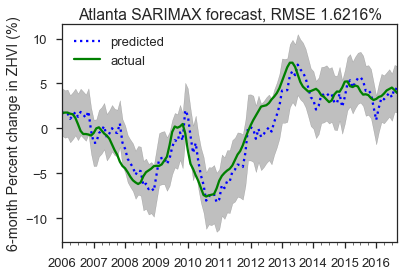

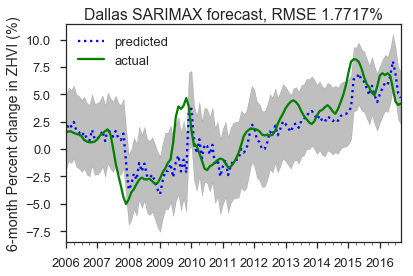

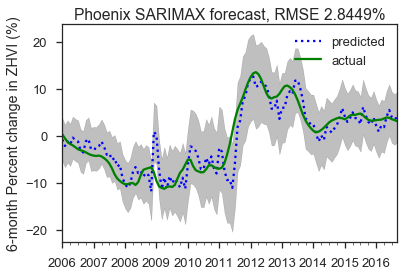

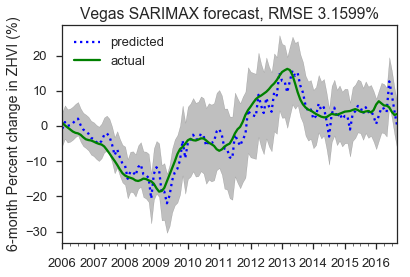

In [48]:
startDate = None
endDate = '2017-03'

exogVars = None
scaleBy  = 1.0

for city in cityList: #['Atlanta']: 
    ts = df.loc[metroString[city],startDate:endDate]
    y = ts

#     ## Exogenous Variables
#     # Compile exogenous variables for that city
#     metroData = metroMonthly[city].loc[ts.index[0]:ts.index[-1],:]
#     metroData = metroData.dropna(axis=1, how='any')
#     natlData  = nationalMonthly.loc[ts.index[0]:ts.index[-1],:]
#     natlData  = natlData.dropna(axis=1, how='any')
#     exogVars  = metroData.join(natlData)
# #     exogVars  = exogVars[['stateInitialUnemplClaims','stateContinuedUnemplClaims']]
# #     exogVars  = exogVars.drop(['stateInitialUnemplClaims','stateContinuedUnemplClaims'], axis=1)
#     exogVars  = exogVars / exogVars.mean(axis=0) # Scale to unit in order to avoid bad conditioning
    
    if exogVars is not None:
        scaleBy = ts.mean()
    
    ## Data prep
    y = y / scaleBy
    trainUntil    = '2005-12'
    trainEndIndex = y.index.get_loc(trainUntil).stop
    trainingEnds  = y.index[trainEndIndex]
    testingStarts = y.index[trainEndIndex + shiftMonths - 1]
    trainDateList = y.loc[trainingEnds:,].index
    testDateList  = y.loc[testingStarts:,].index

    results = pd.DataFrame(index=trainDateList, columns=['lower','predicted','upper'])

    model=smt.SARIMAX(y, order=(36, 2, 36), exog=exogVars, enforce_invertibility=False, enforce_stationarity=False)
    res=model.fit()


    for i in range(len(testDateList)):
        testDate = testDateList[i]
        myForecast = res.get_prediction(start=trainDateList[i],dynamic=True)  # This will run rolling predictions based on the fitted model

        # We want to pull the mean prediction and confidence interval data for the forecast prices n-months into the future
        results.loc[testDate,['lower','upper']] = myForecast.conf_int().loc[testDate,:].values * scaleBy # This is the forecast for the future date
        results.loc[testDate,'predicted'] = myForecast.predicted_mean.loc[testDate] * scaleBy

    scaledResults = results.shift(-shiftMonths,axis=0).divide(ts,axis=0) - 1
    scaledResults = scaledResults * 100
    scaledResults.dropna(inplace=True)

    # Create the ground-truth against which we're comparing this
    actual = ts.pct_change(periods=shiftMonths).shift(-shiftMonths).dropna() * 100
    actual.name = 'actual'
    scaledResults = scaledResults.join(actual,how='inner').dropna()

    ## Plot results 
    ax = scaledResults[['predicted','actual']].plot(style=['b:','g-'])
    ax.set_ylabel('6-month Percent change in ZHVI (%)')
    plt.title('%s SARIMAX forecast, RMSE %.4f%%'%(city,getRMSE(scaledResults['predicted'],scaledResults['actual'])))
    ax.fill_between(scaledResults.index, list(scaledResults['lower'].values), list(scaledResults['upper'].values),color='k',alpha=0.25)

# Using all other cities as exogenous variables

We have all the ZHVI data... why not use it?


In [24]:
exogVars.head()

RegionName,United States,"New York, NY","Los Angeles-Long Beach-Anaheim, CA","Dallas-Fort Worth, TX","Philadelphia, PA","Washington, DC","Miami-Fort Lauderdale, FL","Boston, MA","San Francisco, CA","Riverside, CA",...,"North Vernon, IN","Bainbridge, GA","Thomaston, GA","Greensburg, IN","Mexico, MO","Connersville, IN","Sterling, CO","Grenada, MS","Othello, WA","Vineyard Haven, MA"
1996-04-01,99600.0,165700.0,170600.0,102200.0,106300.0,154200.0,93500.0,149500.0,225200.0,112500.0,...,69100.0,37500.0,39400.0,70300.0,49400.0,60200.0,48200.0,57900.0,47000.0,232700.0
1996-05-01,100000.0,167000.0,170400.0,102100.0,106200.0,154200.0,93200.0,149900.0,225700.0,112300.0,...,70900.0,37600.0,39200.0,72600.0,49400.0,61100.0,48100.0,58200.0,46800.0,225600.0
1996-06-01,100000.0,167200.0,170100.0,102100.0,106300.0,154400.0,92800.0,150200.0,225400.0,112100.0,...,71600.0,38400.0,39200.0,73700.0,50300.0,60700.0,48400.0,58300.0,46900.0,216500.0
1996-07-01,99900.0,166700.0,169900.0,102300.0,106400.0,154500.0,92500.0,150400.0,224400.0,112100.0,...,71300.0,39500.0,39300.0,73500.0,51600.0,59600.0,49500.0,58600.0,47100.0,210300.0
1996-08-01,99800.0,166300.0,169900.0,102400.0,106200.0,154200.0,92500.0,150600.0,224300.0,111900.0,...,71100.0,39800.0,39200.0,73300.0,52500.0,58900.0,51000.0,58900.0,47500.0,209300.0


In [22]:
y.head()

1996-04-01    0.653313
1996-05-01    0.655150
1996-06-01    0.655150
1996-07-01    0.655150
1996-08-01    0.654538
Name: Atlanta, GA, dtype: float64

/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


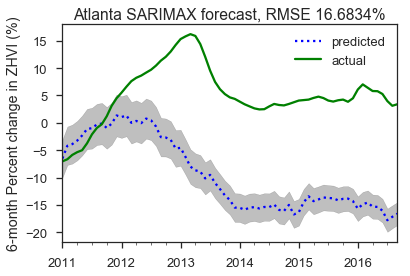

In [42]:
startDate = None
endDate = None
scaleBy = 1.0
exogVars = None

inState = pd.Series(df.index.values).str.contains('GA').values
df = df[inState]

for city in ['Atlanta']:# cityList:
    y = df.loc[metroString[city],:]
    y = y.dropna()
    startDate = y.index.values[0]
    endDate = y.index.values[-1]
    
#     X = df.drop(metroString[city]).loc[:,startDate:endDate]
#     X = X.dropna(how='any')
#     exogVars = X.T
#     exogVars  = exogVars / exogVars.mean(axis=0) # Scale to unit in order to avoid bad conditioning

#     if exogVars is not None:
#         scaleBy = y.mean()
#     y = y / scaleBy
    
    ## Data prep
    trainUntil    = '2005-12'
    trainEndIndex = y.index.get_loc(trainUntil).stop
    trainingEnds  = y.index[trainEndIndex]
    testingStarts = y.index[trainEndIndex + shiftMonths - 1]
    trainDateList = y.loc[trainingEnds:,].index
    testDateList  = y.loc[testingStarts:,].index

    results = pd.DataFrame(index=trainDateList, columns=['lower','predicted','upper'])

    model=smt.SARIMAX(y, order=(6, 2, 6), exog=exogVars, enforce_invertibility=False, enforce_stationarity=False)
    res=model.fit()


    for i in range(len(testDateList)):
        testDate = testDateList[i]
        myForecast = res.get_prediction(start=trainDateList[i],dynamic=True)  # This will run rolling predictions based on the fitted model

        # We want to pull the mean prediction and confidence interval data for the forecast prices n-months into the future
        results.loc[testDate,['lower','upper']] = myForecast.conf_int().loc[testDate,:].values * scaleBy # This is the forecast for the future date
        results.loc[testDate,'predicted'] = myForecast.predicted_mean.loc[testDate] * scaleBy

    scaledResults = results.shift(-shiftMonths,axis=0).divide(ts,axis=0) - 1
    scaledResults = scaledResults * 100
    scaledResults.dropna(inplace=True)

    # Create the ground-truth against which we're comparing this
    actual = ts.pct_change(periods=shiftMonths).shift(-shiftMonths).dropna() * 100
    actual.name = 'actual'
    scaledResults = scaledResults.join(actual,how='inner').dropna()

    ## Plot results 
    ax = scaledResults[['predicted','actual']].plot(style=['b:','g-'])
    ax.set_ylabel('6-month Percent change in ZHVI (%)')
    plt.title('%s SARIMAX forecast, RMSE %.4f%%'%(city,getRMSE(scaledResults['predicted'],scaledResults['actual'])))
    ax.fill_between(scaledResults.index, list(scaledResults['lower'].values), list(scaledResults['upper'].values),color='k',alpha=0.25)

In [54]:
exogVars.head()

RegionName,United States,"New York, NY","Los Angeles-Long Beach-Anaheim, CA","Dallas-Fort Worth, TX","Philadelphia, PA","Washington, DC","Miami-Fort Lauderdale, FL","Boston, MA","San Francisco, CA","Riverside, CA",...,"North Vernon, IN","Bainbridge, GA","Thomaston, GA","Greensburg, IN","Mexico, MO","Connersville, IN","Sterling, CO","Grenada, MS","Othello, WA","Vineyard Haven, MA"
1996-04-01,0.644020,0.511067,0.424330,0.752209,0.601392,0.524758,0.533131,0.489876,0.426644,0.484680,...,0.768400,0.458107,0.583129,0.709156,0.625086,0.901777,0.527336,0.715744,0.486439,0.425283
1996-05-01,0.646607,0.515077,0.423832,0.751473,0.600826,0.524758,0.531420,0.491187,0.427591,0.483819,...,0.788416,0.459328,0.580169,0.732358,0.625086,0.915259,0.526242,0.719452,0.484369,0.412307
1996-06-01,0.646607,0.515693,0.423086,0.751473,0.601392,0.525438,0.529139,0.492170,0.427023,0.482957,...,0.796200,0.469101,0.580169,0.743454,0.636474,0.909267,0.529525,0.720688,0.485404,0.395676
1996-07-01,0.645960,0.514151,0.422589,0.752945,0.601957,0.525778,0.527429,0.492825,0.425128,0.482957,...,0.792864,0.482539,0.581649,0.741436,0.652924,0.892789,0.541559,0.724397,0.487474,0.384345
1996-08-01,0.645313,0.512918,0.422589,0.753681,0.600826,0.524758,0.527429,0.493481,0.424939,0.482095,...,0.790640,0.486204,0.580169,0.739419,0.664312,0.882303,0.557970,0.728105,0.491614,0.382517


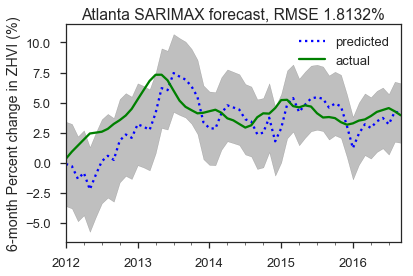

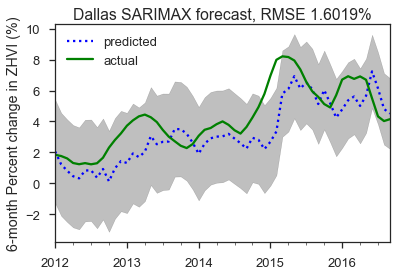

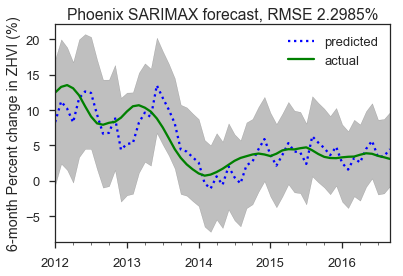

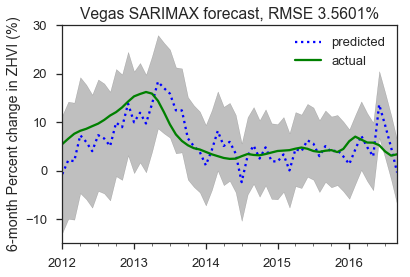

In [72]:
startDate = None
endDate = '2017-03'

exogVars = None
scaleBy  = 1.0

for city in cityList: #['Atlanta']: 
    ts = df.loc[metroString[city],startDate:endDate]
    y = ts

#     exogVars = df.drop(metroString[city]).loc[:,startDate:endDate].dropna(how='any').T
#     exogVars = y

#     ## Exogenous Variables
#     # Compile exogenous variables for that city
#     metroData = metroMonthly[city].loc[ts.index[0]:ts.index[-1],:]
#     metroData = metroData.dropna(axis=1, how='any')
#     natlData  = nationalMonthly.loc[ts.index[0]:ts.index[-1],:]
#     natlData  = natlData.dropna(axis=1, how='any')
#     exogVars  = metroData.join(natlData)
# #     exogVars  = exogVars[['stateInitialUnemplClaims','stateContinuedUnemplClaims']]
# #     exogVars  = exogVars.drop(['stateInitialUnemplClaims','stateContinuedUnemplClaims'], axis=1)
    
    if exogVars is not None:
        exogVars  = exogVars / exogVars.mean(axis=0) # Scale to unit in order to avoid bad conditioning
        scaleBy = ts.mean()
    
    ## Data prep
    y = y / scaleBy
    trainUntil    = '2011-12'
    trainEndIndex = y.index.get_loc(trainUntil).stop
    trainingEnds  = y.index[trainEndIndex]
    testingStarts = y.index[trainEndIndex + shiftMonths - 1]
    trainDateList = y.loc[trainingEnds:,].index
    testDateList  = y.loc[testingStarts:,].index

    results = pd.DataFrame(index=trainDateList, columns=['lower','predicted','upper'])

    model=smt.SARIMAX(y, order=(36, 2, 1), exog=exogVars, enforce_invertibility=False, enforce_stationarity=False)
    res=model.fit()


    for i in range(len(testDateList)):
        testDate = testDateList[i]
        myForecast = res.get_prediction(start=trainDateList[i],dynamic=True)  # This will run rolling predictions based on the fitted model

        # We want to pull the mean prediction and confidence interval data for the forecast prices n-months into the future
        results.loc[testDate,['lower','upper']] = myForecast.conf_int().loc[testDate,:].values * scaleBy # This is the forecast for the future date
        results.loc[testDate,'predicted'] = myForecast.predicted_mean.loc[testDate] * scaleBy

    scaledResults = results.shift(-shiftMonths,axis=0).divide(ts,axis=0) - 1
    scaledResults = scaledResults * 100
    scaledResults.dropna(inplace=True)

    # Create the ground-truth against which we're comparing this
    actual = ts.pct_change(periods=shiftMonths).shift(-shiftMonths).dropna() * 100
    actual.name = 'actual'
    scaledResults = scaledResults.join(actual,how='inner').dropna()

    ## Plot results 
    ax = scaledResults[['predicted','actual']].plot(style=['b:','g-'])
    ax.set_ylabel('6-month Percent change in ZHVI (%)')
    plt.title('%s SARIMAX forecast, RMSE %.4f%%'%(city,getRMSE(scaledResults['predicted'],scaledResults['actual'])))
    ax.fill_between(scaledResults.index, list(scaledResults['lower'].values), list(scaledResults['upper'].values),color='k',alpha=0.25)

In [52]:
exogVars.head()

,metroUnemployment,metroLaborForce,stateInitialUnemplClaims,stateContinuedUnemplClaims,stateLaborForce,metroIncome,csi,cpi,natLaborForce
1996-04-01,0.742063,0.663510,0.597183,0.537880,0.705551,0.784940,1.093575,0.776985,0.883625
1996-05-01,0.744987,0.667476,0.530883,0.499281,0.708982,0.788251,1.066185,0.778476,0.885296
1996-06-01,0.738675,0.671621,0.667713,0.593503,0.712413,0.791563,1.069228,0.778973,0.886967
1996-07-01,0.734838,0.677064,0.604004,0.484193,0.715845,0.795638,1.090531,0.780464,0.888638
1996-08-01,0.729168,0.682537,0.626241,0.581459,0.719565,0.799714,1.093575,0.781956,0.890110


In [61]:
ts.head()

1996-04-01    124600.0
1996-05-01    123900.0
1996-06-01    123300.0
1996-07-01    122900.0
1996-08-01    122600.0
Name: Las Vegas, NV, dtype: float64

In [62]:
ts1 = ts.diff()

In [69]:
ts1[0:10]

1996-04-01      NaN
1996-05-01   -700.0
1996-06-01   -600.0
1996-07-01   -400.0
1996-08-01   -300.0
1996-09-01    200.0
1996-10-01    200.0
1996-11-01    400.0
1996-12-01    500.0
1997-01-01    700.0
Name: Las Vegas, NV, dtype: float64

In [ ]:
ts2.head().cumsum() + ts1.dropna().iloc[0]

In [71]:
ts.iloc[1]+(ts2.head().cumsum() + ts1.dropna().iloc[0]).cumsum()

1996-06-01    123300.0
1996-07-01    122900.0
1996-08-01    122600.0
1996-09-01    122800.0
1996-10-01    123000.0
Name: Las Vegas, NV, dtype: float64

In [66]:
ts2 = ts1.diff().dropna()
(ts2.head().cumsum() + ts1.iloc[0]).cumsum()

1996-06-01    100.0
1996-07-01    200.0
1996-08-01    100.0
1996-09-01    500.0
1996-10-01      0.0
Name: Las Vegas, NV, dtype: float64

In [64]:
ts.iloc[0]+ts1.dropna().cumsum()

1996-05-01    123900.0
1996-06-01    123300.0
1996-07-01    122900.0
1996-08-01    122600.0
1996-09-01    122800.0
1996-10-01    123000.0
1996-11-01    123400.0
1996-12-01    123900.0
1997-01-01    124600.0
1997-02-01    125200.0
1997-03-01    125800.0
1997-04-01    126100.0
1997-05-01    126300.0
1997-06-01    126500.0
1997-07-01    126700.0
1997-08-01    126800.0
1997-09-01    127000.0
1997-10-01    127200.0
1997-11-01    127200.0
1997-12-01    127500.0
1998-01-01    128000.0
1998-02-01    128300.0
1998-03-01    128300.0
1998-04-01    128400.0
1998-05-01    128500.0
1998-06-01    128800.0
1998-07-01    129500.0
1998-08-01    130200.0
1998-09-01    130600.0
1998-10-01    131100.0
                ...   
2014-10-01    178900.0
2014-11-01    179700.0
2014-12-01    180800.0
2015-01-01    181800.0
2015-02-01    182800.0
2015-03-01    183700.0
2015-04-01    184600.0
2015-05-01    185900.0
2015-06-01    187600.0
2015-07-01    189200.0
2015-08-01    190400.0
2015-09-01    191500.0
2015-10-01 